In [123]:
import numpy as np

def sample_bimodal_gaussian(
    mu1: float, sigma1: float,
    mu2: float, sigma2: float,
    size: int = 1,
    weight: float = 0.5
) -> np.ndarray:
    """
    Generate random samples from a bimodal Gaussian (mixture of two Gaussians).

    Args:
        mu1 (float): Mean of the first Gaussian.
        sigma1 (float): Std dev of the first Gaussian.
        mu2 (float): Mean of the second Gaussian.
        sigma2 (float): Std dev of the second Gaussian.
        weight (float): Probability of sampling from the first Gaussian (0 to 1).
        size (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of random samples from the bimodal distribution.
    """
    choices = np.random.rand(size) < weight
    samples = np.empty(size)
    samples[choices] = np.random.normal(mu1, sigma1, np.sum(choices))
    samples[~choices] = np.random.normal(mu2, sigma2, np.sum(~choices))
    samples[samples < 0] = 0
    return samples 

# Throw Q A T1

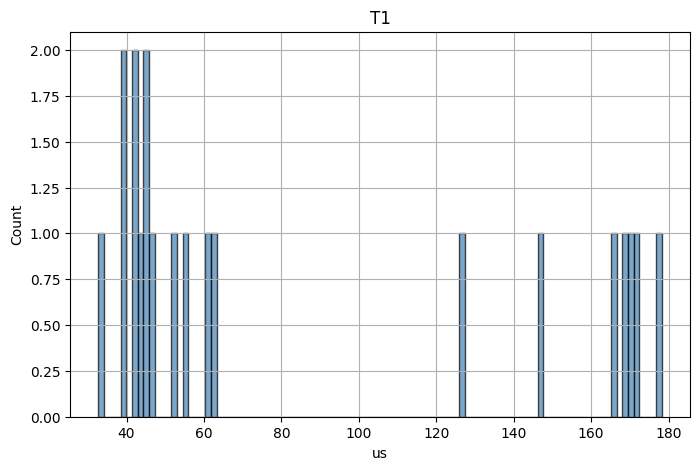

In [155]:
T1_A_SAMPLE = sample_bimodal_gaussian(50e-6,10e-6,170e-6,20e-6,20)

# Drawn from PDF
plt.figure(figsize=(8, 5))
plt.hist(T1_A_SAMPLE*1e6, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel("us")
plt.ylabel("Count")
plt.title("T1")
plt.grid(True)
plt.show()

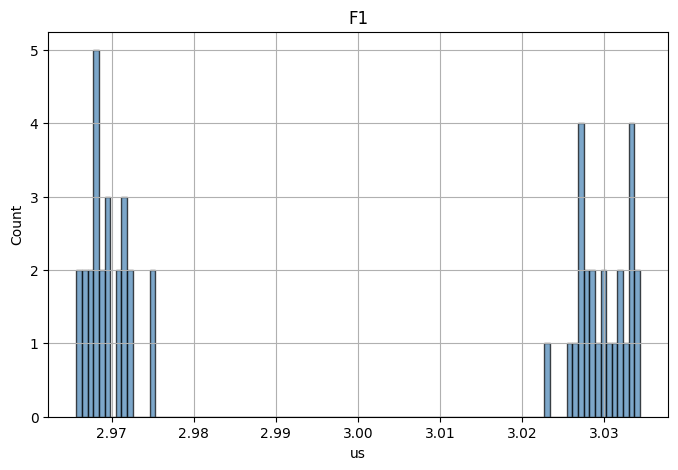

In [104]:
_lo = 3.000e9 - 30e6
_hi = 3.000e9 + 30e6
_s  = 3e6
F_A_SAMPLE = sample_bimodal_gaussian(_lo,_s,_hi,_s,50)

# Drawn from PDF
plt.figure(figsize=(8, 5))
plt.hist(F_A_SAMPLE/1e9, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel("us")
plt.ylabel("Count")
plt.title("F1")
plt.grid(True)
plt.show()

## with ZZ coupling

In [156]:

# Two-qubit simultaneous-Ramsey with ZZ coupling + T1/T2
# ---------------------------------------------------------------
import numpy as np, qutip as qt, matplotlib.pyplot as plt
from datetime import datetime

expA_list = []
expB_list = []
#T1_A_SAMPLE = [10e-6, 20e-6, 30e-6]
counter = 0 

for iQ_A in T1_A_SAMPLE:
    if counter%10==0:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        print(f'loop: {counter} time: {timestamp}')
    counter+=1
        
    #fA = iQ_A #3.000e9          # qubit bare freqs  (Hz)
    fA = 3.000e9          # qubit bare freqs  (Hz)
    fB = 3.040e9
    detA = detB = 3e6                  # Ramsey detuning   (Hz)
    chi_MHz     = 0.01 #0.6                   # ZZ  (MHz)  (0 → no beating)

    #T1_A = 110e-6 # iQ_A 
    T1_A = iQ_A
    T1_B = 170e-6                       # T1  (s)
    T2_A = 110e-6
    T2_B = 190e-6                 # desired T2 (s)

    t_ns = np.linspace(0, 5000, 401)    # free-evolution delays (ns)


    wA,wB   = 2*np.pi*np.array([fA,fB])
    chi     = 2*np.pi*chi_MHz*1e6
    EdA,EdB = 0.01*wA, 0.01*wB          # Rabi → τπ/2≈8 ns
    pi2A,pi2B = np.pi/(2*EdA), np.pi/(2*EdB)
    tau_p   = float(max(pi2A,pi2B))

    I,sx,sz,sm = qt.qeye(2),qt.sigmax(),qt.sigmaz(),qt.destroy(2)
    sxA,sxB = qt.tensor(sx,I), qt.tensor(I,sx)
    szA,szB = qt.tensor(sz,I), qt.tensor(I,sz)
    smA,smB = qt.tensor(sm,I), qt.tensor(I,sm)
    nA,nB   = qt.tensor(qt.num(2),I),   qt.tensor(I,qt.num(2))

    # ─── Collapse operators for given T1 and T2 ─────────────────
    def collapse_ops(T1,T2,sm_op,sz_op):
        g1  = 1/T1
        gphi = max(0, 1/T2 - g1/2)      # 1/T2 = 1/(2T1)+1/Tphi
        return [np.sqrt(g1)*sm_op, np.sqrt(gphi)*sz_op]

    c_ops = ( collapse_ops(T1_A,T2_A,smA,szA) +
              collapse_ops(T1_B,T2_B,smB,szB) )

    # ─── Static Hamiltonian ───────────────────────────
    H0 = 0.5*wA*szA + 0.5*wB*szB + chi/4*szA*szB
    def gate_coeff(ω,amp,t0,t1):
        return lambda t,args=None: amp*np.cos(ω*t) if t0<=t<t1 else 0.0

    def H_sequence(delay_s):
        t1s,t1e = 0.0,        pi2A
        t2s,t2e = tau_p,      tau_p+pi2A
        return [H0,
                [sxA, gate_coeff(wA+2*np.pi*detA, EdA, t1s, t1e)],
                [sxB, gate_coeff(wB+2*np.pi*detB, EdB, t1s, pi2B)],
                [sxA, gate_coeff(wA+2*np.pi*detA, EdA, t2s+delay_s, t2e+delay_s)],
                [sxB, gate_coeff(wB+2*np.pi*detB, EdB, t2s+delay_s, pi2B+tau_p+delay_s)]], \
               2*tau_p + delay_s

    # ───  Ramsey point (single integration) ──────────────────────
    opts = qt.Options(nsteps=20000, store_final_state=True, atol=1e-7, rtol=1e-6)
    psi_g = qt.tensor(qt.basis(2,0), qt.basis(2,0))

    def ramsey(delay_ns):
        τ = delay_ns*1e-9
        H,t_tot = H_sequence(τ)
        tlist = np.linspace(0,t_tot,int(t_tot/2e-9)+1)  # 2-ns solver step
        st = qt.mesolve(H, psi_g, tlist, c_ops, e_ops=[], options=opts).states[-1]
        return qt.expect(nA,st), qt.expect(nB,st)

    expA,expB = np.array(qt.parallel_map(ramsey,t_ns,progress_bar=True)).T
    #expA,expB = np.array([ramsey(t) for t in t_ns]).T

    expA_list.append(expA)
    expB_list.append(expB)    

# write to file
# Create a timestamp string
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create filename
filename = f"results_{timestamp}.npz"

# Save the lists to a compressed npz file
np.savez(filename, expA=expA, expB=expB, T1_A_SAMPLE=T1_A_SAMPLE)

print(f"Saved results to {filename}")


loop: 0 time: 20250721_105818
10.2%. Run time:   1.57s. Est. time left: 00:00:00:13
20.2%. Run time:   2.59s. Est. time left: 00:00:00:10
30.2%. Run time:   4.41s. Est. time left: 00:00:00:10
40.1%. Run time:   6.50s. Est. time left: 00:00:00:09
50.1%. Run time:   8.90s. Est. time left: 00:00:00:08
60.1%. Run time:  11.91s. Est. time left: 00:00:00:07
70.1%. Run time:  14.97s. Est. time left: 00:00:00:06
80.0%. Run time:  19.02s. Est. time left: 00:00:00:04
90.0%. Run time:  21.62s. Est. time left: 00:00:00:02
100.0%. Run time:  24.10s. Est. time left: 00:00:00:00
Total run time:  24.19s
10.2%. Run time:   1.39s. Est. time left: 00:00:00:12
20.2%. Run time:   2.44s. Est. time left: 00:00:00:09
30.2%. Run time:   4.23s. Est. time left: 00:00:00:09
40.1%. Run time:   6.35s. Est. time left: 00:00:00:09
50.1%. Run time:   8.74s. Est. time left: 00:00:00:08
60.1%. Run time:  11.86s. Est. time left: 00:00:00:07
70.1%. Run time:  15.09s. Est. time left: 00:00:00:06
80.0%. Run time:  19.06s. E

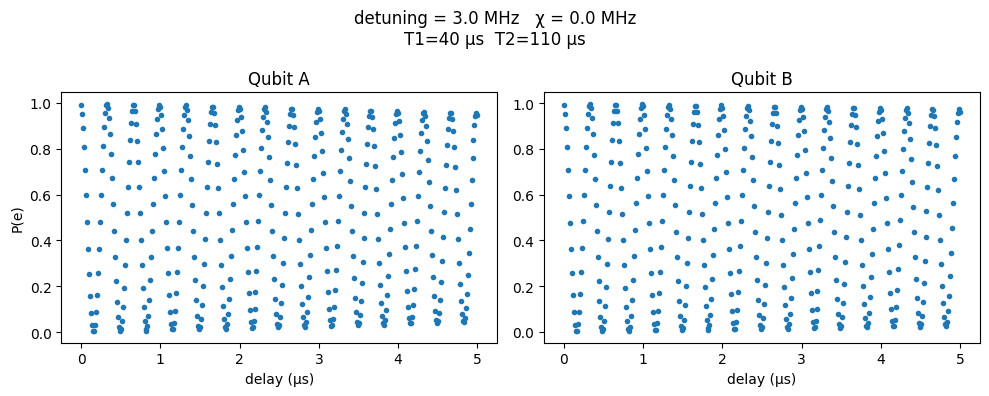

In [157]:
expA = expA_list[0]
expB = expB_list[0]
    
# ───  Plot ───────────────────────────────────────────────────
plt.figure(figsize=(10,4))
plt.subplot(121); plt.plot(t_ns/1000,expA,'.'); plt.title('Qubit A'); plt.xlabel('delay (µs)'); plt.ylabel('P(e)')
plt.subplot(122); plt.plot(t_ns/1000,expB,'.'); plt.title('Qubit B'); plt.xlabel('delay (µs)')
plt.suptitle(f'detuning = {detA/1e6:.1f} MHz   χ = {chi_MHz:.1f} MHz\nT1={T1_A*1e6:.0f} µs  T2={T2_A*1e6:.0f} µs')
plt.tight_layout(); plt.show()

## FIT with one amplitude
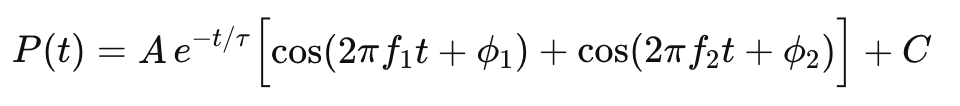

In [162]:
# ==================================================================
# Fit Ramsey beating to two decaying cosines  (requires SciPy ≥1.6)
# ==================================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import rfftfreq, rfft

# --- model --------------------------------------------------------
def double_cos(t_s, A, f1, f2, phi1, phi2, T2, C):
    env = A * np.exp(-t_s / T2)
    return env * (np.cos(2*np.pi*f1*t_s + phi1) +
                  np.cos(2*np.pi*f2*t_s + phi2)) + C

# --- helper: crude initial guesses from FFT ----------------------
def guess_params(t_ns, y):
    t_s = t_ns*1e-9
    C0  = y.mean()
    A0  = 0.5*(y.max()-y.min())
    fs  = rfftfreq(len(t_s), t_s[1]-t_s[0])
    spec= np.abs(rfft(y-C0))
    peak_idx = spec.argsort()[-2:][::-1]   # two largest peaks
    f1, f2 = fs[peak_idx]
    return [A0, f1, f2, 0, 0, 5e-6, C0]

# --- report -------------------------------------------------------
def report(label, p):
    print(f"{label}:  f1 = {p[1]/1e6:.3f} MHz   f2 = {p[2]/1e6:.3f} MHz   "
          f"T2 = {p[5]*1e6:.1f} µs")
    
expA_t2 = []
expB_t2 = []
expA_p = []
expB_p = []

for expA, expB in zip(expA_list, expB_list):
    # --- fit both qubits ---------------------------------------------
    p0A = guess_params(t_ns, expA)
    p0B = guess_params(t_ns, expB)
    t_s = t_ns*1e-9

    bounds = ([0,0,0,-np.pi,-np.pi,0,0],
              [1,20e6,20e6,np.pi,np.pi,1e-3,1])

    #pA,_ = curve_fit(double_cos, t_s, expA, p0=p0A, bounds=bounds, maxfev=30000)
    #pB,_ = curve_fit(double_cos, t_s, expB, p0=p0B, bounds=bounds, maxfev=30000)

    pA,_ = curve_fit(double_cos, t_s, expA, p0=p0A,  maxfev=30000)
    pB,_ = curve_fit(double_cos, t_s, expB, p0=p0B,  maxfev=30000)

    report("Qubit-A", pA)
    report("Qubit-B", pB)

    expA_t2.append(pA[5])
    expB_t2.append(pB[5])

    expA_p.append(pA)
    expB_p.append(pB)


Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 63.6 µs
Qubit-B:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 122.8 µs
Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 94.0 µs
Qubit-B:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 122.0 µs
Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 86.8 µs
Qubit-B:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 121.5 µs
Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 63.8 µs
Qubit-B:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 122.8 µs
Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 63.0 µs
Qubit-B:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 122.9 µs
Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 74.3 µs
Qubit-B:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 121.2 µs
Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 95.7 µs
Qubit-B:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 122.0 µs
Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 63.5 µs
Qubit-B:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 122.8 µs
Qubit-A:  f1 = 3.001 MHz   f2 = 3.288 MHz   T2 = 99.2 µs
Qubit-B:  f1 = 3.001 MH

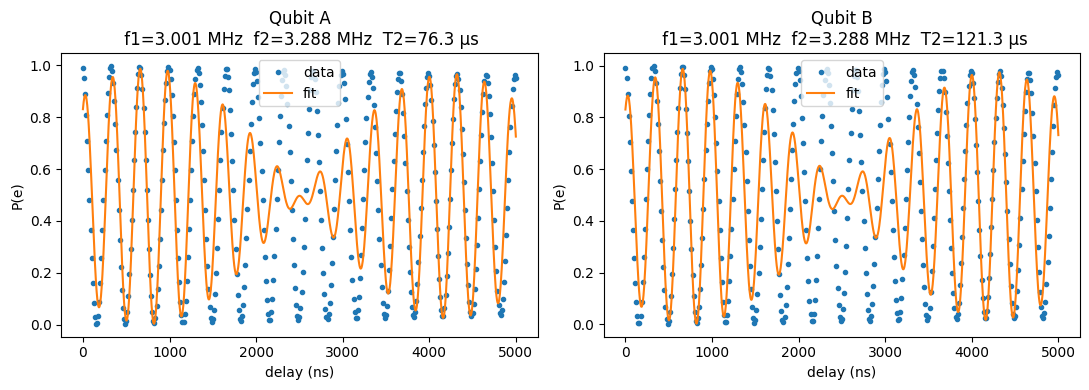

In [163]:
i=19
expA = expA_list[i]
expB = expB_list[i]
pA = expA_p[i]
pB = expB_p[i]

# --- plots ------------------------------------------------
tf_ns = np.linspace(t_ns[0], t_ns[-1], 1200)
fig, ax = plt.subplots(1,2, figsize=(11,4))
for k,(y,p,title) in enumerate(zip((expA,expB),(pA,pB),("Qubit A","Qubit B"))):
    ax[k].plot(t_ns, y, '.', label='data')
    ax[k].plot(tf_ns,
               double_cos(tf_ns*1e-9, *p), label='fit')
    ax[k].set_title(title+
        f"\n f1={p[1]/1e6:.3f} MHz  f2={p[2]/1e6:.3f} MHz  T2={p[5]*1e6:.1f} µs")
    ax[k].set_xlabel('delay (ns)'); ax[k].set_ylabel('P(e)')
    ax[k].legend()
plt.tight_layout(); plt.show()

## fit with two amplitudes 
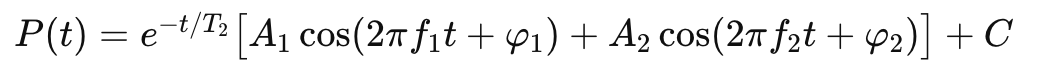

Qubit-A:  f1 = 3.299 MHz   f2 = 2.699 MHz   A1 = 0.23  A2 = 0.27   T2 = 2.5 µs
Qubit-B:  f1 = 3.299 MHz   f2 = 2.698 MHz   A1 = 0.23  A2 = 0.27   T2 = 2.5 µs


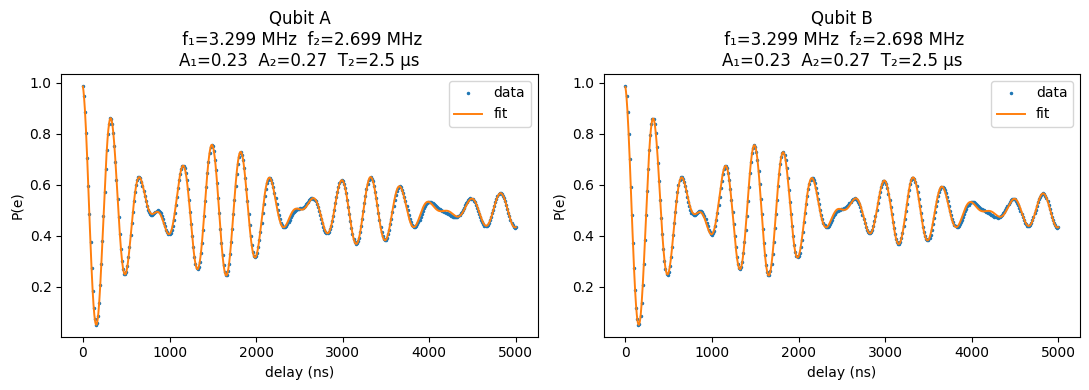

In [4]:
# ==================================================================
# Fit Ramsey beating with *independent* amplitudes for each branch
# Assumes t_ns, expA, expB are defined (from the simulation cell)
# ==================================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import rfftfreq, rfft

# ---------- model -------------------------------------------------
def two_amp_cos(t_s, A1, A2, f1, f2, phi1, phi2, T2, C):
    env = np.exp(-t_s / T2)
    return env * (A1*np.cos(2*np.pi*f1*t_s + phi1) +
                  A2*np.cos(2*np.pi*f2*t_s + phi2)) + C

# ---------- initial-guess helper (FFT) ---------------------------
def guess_params(t_ns, y):
    t_s = t_ns * 1e-9
    C0  = y.mean()
    
    y0  = y - C0
    A_guess = 0.5*(y.max()-y.min())
    fs   = rfftfreq(len(t_s), t_s[1]-t_s[0])
    spec = np.abs(rfft(y0))
    idx  = spec.argsort()[-2:][::-1]          # two largest peaks
    f1, f2 = fs[idx]
    return [A_guess, A_guess, f1, f2, 0.0, 0.0, 5e-6, C0]

# ---------- fit both qubits --------------------------------------
t_s = t_ns * 1e-9
p0A = guess_params(t_ns, expA)
p0B = guess_params(t_ns, expB)

bounds = ([0,0,      0,      0, -np.pi, -np.pi,        0, 0],   # lower
          [1,1,  20e6,  20e6,  np.pi,  np.pi,   1e-3, 1])       # upper

pA, _ = curve_fit(two_amp_cos, t_s, expA, p0=p0A,
                  bounds=bounds, maxfev=50000)
pB, _ = curve_fit(two_amp_cos, t_s, expB, p0=p0B,
                  bounds=bounds, maxfev=50000)

# ---------- report ----------------------------------------------
def report(label, p):
    print(f"{label}:  f1 = {p[2]/1e6:.3f} MHz   "
          f"f2 = {p[3]/1e6:.3f} MHz   "
          f"A1 = {p[0]:.2f}  A2 = {p[1]:.2f}   "
          f"T2 = {p[6]*1e6:.1f} µs")

report("Qubit-A", pA)
report("Qubit-B", pB)

# ---------- plots ---------------------------------------
tf_ns = np.linspace(t_ns[0], t_ns[-1], 1600)
fig, ax = plt.subplots(1,2, figsize=(11,4))
for k, (y, p, title) in enumerate(zip((expA, expB),
                                      (pA, pB),
                                      ("Qubit A", "Qubit B"))):
    ax[k].plot(t_ns, y, '.', ms=3, label='data')
    ax[k].plot(tf_ns,
               two_amp_cos(tf_ns*1e-9, *p), lw=1.4, label='fit')
    ax[k].set_title(title +
      (f"\n f₁={p[2]/1e6:.3f} MHz  f₂={p[3]/1e6:.3f} MHz\n"
       f"A₁={p[0]:.2f}  A₂={p[1]:.2f}  T₂={p[6]*1e6:.1f} µs"))
    ax[k].set_xlabel('delay (ns)'); ax[k].set_ylabel('P(e)')
    ax[k].legend()
plt.tight_layout(); plt.show()


# Sample Telegraphic Noise 

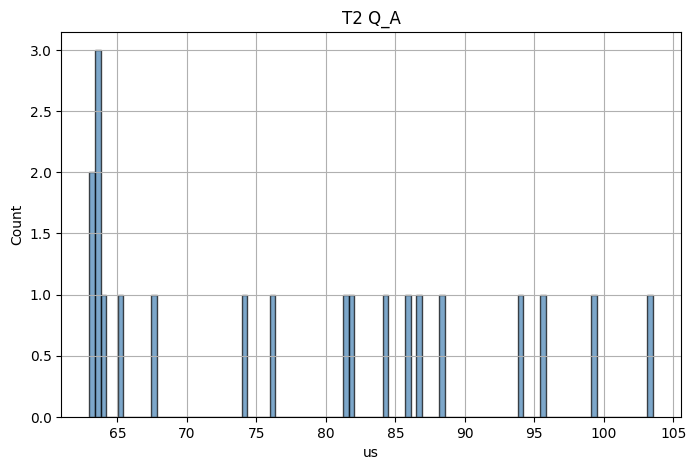

In [160]:
# Q A
plt.figure(figsize=(8, 5))
plt.hist(np.array(expA_t2)*1e6, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel("us")
plt.ylabel("Count")
plt.title("T2 Q_A")
plt.grid(True)
plt.show()

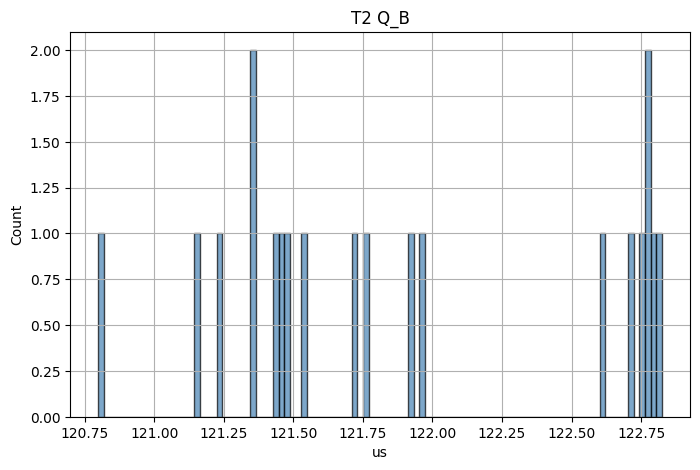

In [161]:
# Q B
plt.figure(figsize=(8, 5))
plt.hist(np.array(expB_t2)*1e6, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel("us")
plt.ylabel("Count")
plt.title("T2 Q_B")
plt.grid(True)
plt.show()

In [108]:
# rabi osc pi pulse
i=np.argmax(expB_t2)
print(i, expB_t2[i])

19 0.000999999999999807
